# March Madness Box Score Data Analyzer

This notebook provides a comprehensive analysis of NCAA Men's Basketball team box scores from 2003-2023. We'll explore team performance, statistics, and trends across multiple seasons.

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import glob
import os
from pathlib import Path
import warnings

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Current working directory: {os.getcwd()}")

Libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 1.26.4
Current working directory: /users/bzheng2/Private/March-Madness-Predictor


## Data Loading Functions

Let's create functions to efficiently load and work with the compressed CSV files.

In [170]:
class BoxScoreAnalyzer:
    """A class for analyzing NCAA basketball box score data."""
    
    def __init__(self, data_dir="data/csv"):
        self.data_dir = Path(data_dir)
        self.available_years = self._get_available_years()
        self.data_cache = {}
        print(f"Found data for years: {sorted(self.available_years)}")
    
    def _get_available_years(self):
        """Get list of available years from CSV files."""
        csv_files = glob.glob(str(self.data_dir / "team_box_*.csv.gz"))
        years = []
        for file in csv_files:
            year = int(file.split('_')[-1].split('.')[0])
            years.append(year)
        return years
    
    def load_year_data(self, year):
        """Load data for a specific year."""
        if year not in self.available_years:
            raise ValueError(f"Year {year} not available. Available years: {self.available_years}")
        
        if year in self.data_cache:
            return self.data_cache[year]
        
        file_path = self.data_dir / f"team_box_{year}.csv.gz"
        print(f"Loading data for {year}...")
        
        with gzip.open(file_path, 'rt') as f:
            df = pd.read_csv(f)
        
        # Parse datetime columns
        if 'game_date' in df.columns:
            df['game_date'] = pd.to_datetime(df['game_date'])
        if 'game_date_time' in df.columns:
            df['game_date_time'] = pd.to_datetime(df['game_date_time'])
        
        self.data_cache[year] = df
        print(f"Loaded {len(df)} records for {year}")
        return df
    
    def load_multiple_years(self, years):
        """Load data for multiple years and combine."""
        dfs = []
        for year in years:
            df = self.load_year_data(year)
            dfs.append(df)
        
        combined = pd.concat(dfs, ignore_index=True)
        print(f"Combined data: {len(combined)} total records across {len(years)} years")
        return combined
    
    def load_all_data(self):
        """Load all available data."""
        return self.load_multiple_years(self.available_years)

# Initialize the analyzer
analyzer = BoxScoreAnalyzer()

# Load a sample year to explore the structure
sample_data = analyzer.load_year_data(2023)
print(f"\nSample data shape: {sample_data.shape}")
print(f"Columns: {len(sample_data.columns)}")
print("\nColumns:")
print(sample_data.columns[:].tolist())

Found data for years: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Loading data for 2023...
Loaded 12370 records for 2023

Sample data shape: (12370, 54)
Columns: 54

Columns:
['game_id', 'season', 'season_type', 'game_date', 'game_date_time', 'team_id', 'team_uid', 'team_slug', 'team_location', 'team_name', 'team_abbreviation', 'team_display_name', 'team_short_display_name', 'team_color', 'team_alternate_color', 'team_logo', 'team_home_away', 'team_score', 'team_winner', 'assists', 'blocks', 'defensive_rebounds', 'field_goal_pct', 'field_goals_made', 'field_goals_attempted', 'flagrant_fouls', 'fouls', 'free_throw_pct', 'free_throws_made', 'free_throws_attempted', 'largest_lead', 'offensive_rebounds', 'steals', 'team_turnovers', 'technical_fouls', 'three_point_field_goal_pct', 'three_point_field_goals_made', 'three_point_field_goals_attempted', 'total_rebounds', 'total_technical_fouls', 'total_turnovers',

## Data Inspection
Find out the format diff between years

In [171]:
# Load data for all available years and inspect column differences
print("LOADING ALL YEARS TO INSPECT COLUMN DIFFERENCES")
print("=" * 60)

# Load data for each year and compare columns
all_year_columns = {}
column_sets = {}

for year in sorted(analyzer.available_years):
    print(f"\nLoading and inspecting {year}...")
    year_data = analyzer.load_year_data(year)
    
    # Store columns for this year
    year_columns = set(year_data.columns)
    all_year_columns[year] = year_columns
    column_sets[year] = len(year_columns)
    
    print(f"  Shape: {year_data.shape}")
    print(f"  Columns: {len(year_columns)}")

# Find common columns across all years
print(f"\nCOLUMN ANALYSIS ACROSS ALL YEARS:")
print("=" * 50)

all_columns = set()
for year_cols in all_year_columns.values():
    all_columns.update(year_cols)

common_columns = all_columns.copy()
for year_cols in all_year_columns.values():
    common_columns &= year_cols

print(f"Total unique columns across all years: {len(all_columns)}")
print(f"Common columns in all years: {len(common_columns)}")

# Show column count by year
print(f"\nCOLUMN COUNT BY YEAR:")
for year in sorted(column_sets.keys()):
    print(f"  {year}: {column_sets[year]} columns")

# Find year-specific columns
print(f"\nYEAR-SPECIFIC COLUMN DIFFERENCES:")
print("=" * 40)

for year in sorted(all_year_columns.keys()):
    year_specific = all_year_columns[year] - common_columns
    if year_specific:
        print(f"\n{year} has {len(year_specific)} unique columns:")
        for col in sorted(year_specific):
            print(f"  - {col}")
    else:
        print(f"\n{year}: No unique columns")

# Find missing columns by year
print(f"\nMISSING COLUMNS BY YEAR:")
print("=" * 30)

for year in sorted(all_year_columns.keys()):
    missing_cols = all_columns - all_year_columns[year]
    if missing_cols:
        print(f"\n{year} missing {len(missing_cols)} columns:")
        for col in sorted(missing_cols)[:10]:  # Show first 10
            print(f"  - {col}")
        if len(missing_cols) > 10:
            print(f"  ... and {len(missing_cols) - 10} more")
    else:
        print(f"\n{year}: No missing columns")

print(f"\n✓ Column inspection complete!")
print(f"This analysis will help us understand data consistency across years")

LOADING ALL YEARS TO INSPECT COLUMN DIFFERENCES

Loading and inspecting 2003...
Loading data for 2003...
Loaded 2 records for 2003
  Shape: (2, 41)
  Columns: 41

Loading and inspecting 2004...
Loading data for 2004...
Loaded 24 records for 2004
  Shape: (24, 55)
  Columns: 55

Loading and inspecting 2005...
Loading data for 2005...


Loaded 8836 records for 2005
  Shape: (8836, 55)
  Columns: 55

Loading and inspecting 2006...
Loading data for 2006...
Loaded 9846 records for 2006
  Shape: (9846, 55)
  Columns: 55

Loading and inspecting 2007...
Loading data for 2007...
Loaded 10488 records for 2007
  Shape: (10488, 55)
  Columns: 55

Loading and inspecting 2008...
Loading data for 2008...
Loaded 11094 records for 2008
  Shape: (11094, 55)
  Columns: 55

Loading and inspecting 2009...
Loading data for 2009...
Loaded 11278 records for 2009
  Shape: (11278, 55)
  Columns: 55

Loading and inspecting 2010...
Loading data for 2010...
Loaded 11496 records for 2010
  Shape: (11496, 55)
  Columns: 55

Loading and inspecting 2011...
Loading data for 2011...
Loaded 11294 records for 2011
  Shape: (11294, 41)
  Columns: 41

Loading and inspecting 2012...
Loading data for 2012...
Loaded 11288 records for 2012
  Shape: (11288, 41)
  Columns: 41

Loading and inspecting 2013...
Loading data for 2013...
Loaded 11368 records for 201

## All Raw Columns in Combined Dataset

We notice there's some inconsistency in data. Let's first display all the columns available in our complete combined dataset with their null percentages.

In [172]:
all_years_data = analyzer.load_all_data()
print(f"\nCOMPLETE DATASET SUMMARY:")
print(f"Shape: {all_years_data.shape}")
print(f"Years included: {sorted(all_years_data['season'].unique())}")
print(f"Total games: {len(all_years_data):,}")
print(f"Date range: {all_years_data['game_date'].min()} to {all_years_data['game_date'].max()}")
print(f"Memory usage: {all_years_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display all raw columns in the complete dataset with null percentages
print("ALL RAW COLUMNS IN THE COMBINED DATASET")
print("=" * 70)
print(f"Total columns: {len(all_years_data.columns)}")
print()
print(f"{'#':<3} {'Column Name':<40} {'Null Count':<12} {'Null %':<8}")
print("-" * 70)

for i, col in enumerate(all_years_data.columns, 1):
    null_count = all_years_data[col].isnull().sum()
    null_percentage = (null_count / len(all_years_data)) * 100
    print(f"{i:2d}. {col:<40} {null_count:<12,} {null_percentage:<7.1f}%")

Combined data: 211432 total records across 21 years

COMPLETE DATASET SUMMARY:
Shape: (211432, 64)
Years included: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Total games: 211,432
Date range: 2003-03-10 00:00:00 to 2023-04-03 00:00:00
Memory usage: 351.9 MB
ALL RAW COLUMNS IN THE COMBINED DATASET
Total columns: 64

#   Column Name                              Null Count   Null %  
----------------------------------------------------------------------
 1. team_short_display_name                  1            0.0    %
 2. team_uid                                 0            0.0    %
 3. team_alternate_color                     23,440       11.1   %
 4. team_color                               2,977        1.4    %
 5. team_display_name                        0            0.0    %
 6. team_name                                380          0.2    %
 7. team_logo                                5,843        2.

## Data Cleaning: Remove Unnecessary Columns

Let's clean up the dataset by removing visual/branding columns and redundant team identifiers, keeping only essential data for analysis.

In [173]:
# Define columns to drop - logos, colors, mascots, and redundant team identifiers
columns_to_drop = [
    # Team visual/branding columns (logos, colors)
    'team_logo', 'team_color', 'team_alternate_color',
    'opponent_team_logo', 'opponent_team_color', 'opponent_team_alternate_color',
    
    # Mascot/name redundancy - keep only essential identifiers
    'opponent_mascot',
    
    # Redundant team identifiers - keep only team_id
    'team_uid', 'team_slug', 'team_abbreviation', 
    'team_display_name', 'team_short_display_name', 'team_name',
    
    # Redundant opponent identifiers
    'opponent_team_uid', 'opponent_team_slug', 
    'opponent_team_abbreviation', 'opponent_team_display_name', 'opponent_team_name', 'opponent_abbrev', 'opponent_name',
    'opponent_team_short_display_name',

    'largestLead', # this is just a col that every row is missing
]

print("COLUMNS TO DROP:")
print("="*60)
print(f"Total columns to drop: {len(columns_to_drop)}")

# Check which columns actually exist in our dataset
existing_columns_to_drop = [col for col in columns_to_drop if col in all_years_data.columns]
missing_columns = [col for col in columns_to_drop if col not in all_years_data.columns]

print(f"Columns that exist and will be dropped: {len(existing_columns_to_drop)}")
for i, col in enumerate(existing_columns_to_drop, 1):
    print(f"  {i:2d}. {col}")

if missing_columns:
    print(f"\nColumns not found in dataset: {len(missing_columns)}")
    for i, col in enumerate(missing_columns, 1):
        print(f"  {i:2d}. {col}")

# Create cleaned dataset
print(f"\nCLEANING DATASET:")
print("="*60)
print(f"Original shape: {all_years_data.shape}")

cleaned_data = all_years_data.drop(columns=existing_columns_to_drop)

print(f"Cleaned shape: {cleaned_data.shape}")
print(f"Columns removed: {len(existing_columns_to_drop)}")
print(f"Columns remaining: {cleaned_data.shape[1]}")

# Show remaining team identifier columns
team_id_cols = [col for col in cleaned_data.columns if col.startswith('team_') and 'id' in col.lower()]
opponent_id_cols = [col for col in cleaned_data.columns if col.startswith('opponent_') and 'id' in col.lower()]

print(f"\nREMAINING TEAM IDENTIFIERS:")
print(f"Team ID columns: {team_id_cols}")
print(f"Opponent ID columns: {opponent_id_cols}")

# Verify we kept essential columns
essential_cols = ['team_id', 'opponent_team_id']
kept_essential = [col for col in essential_cols if col in cleaned_data.columns]
missing_essential = [col for col in essential_cols if col not in cleaned_data.columns]

print(f"\nESSENTIAL COLUMNS CHECK:")
print(f"Essential columns kept: {kept_essential}")
if missing_essential:
    print(f"Essential columns missing: {missing_essential}")

print(f"\n✓ Dataset cleaned successfully!")
print(f"Removed visual/branding columns and redundant identifiers")
all_years_data = cleaned_data  # Update reference for further analysis

COLUMNS TO DROP:
Total columns to drop: 22
Columns that exist and will be dropped: 22
   1. team_logo
   2. team_color
   3. team_alternate_color
   4. opponent_team_logo
   5. opponent_team_color
   6. opponent_team_alternate_color
   7. opponent_mascot
   8. team_uid
   9. team_slug
  10. team_abbreviation
  11. team_display_name
  12. team_short_display_name
  13. team_name
  14. opponent_team_uid
  15. opponent_team_slug
  16. opponent_team_abbreviation
  17. opponent_team_display_name
  18. opponent_team_name
  19. opponent_abbrev
  20. opponent_name
  21. opponent_team_short_display_name
  22. largestLead

CLEANING DATASET:
Original shape: (211432, 64)
Cleaned shape: (211432, 42)
Columns removed: 22
Columns remaining: 42

REMAINING TEAM IDENTIFIERS:
Team ID columns: ['team_id']
Opponent ID columns: ['opponent_id', 'opponent_team_id']

ESSENTIAL COLUMNS CHECK:
Essential columns kept: ['team_id', 'opponent_team_id']

✓ Dataset cleaned successfully!
Removed visual/branding columns a

## Let's calculate those missing scores

In [174]:
# Calculate Missing Team Scores
print("\nTEAM SCORE CALCULATION")
print("=" * 70)

# Method 1: Try separate columns (works for 2004-2010, 2023)
print("METHOD 1: Using separate shooting statistic columns")
print("-" * 50)

required_cols = ['field_goals_made', 'three_point_field_goals_made', 'free_throws_made']
available_separate = [col for col in required_cols if col in all_years_data.columns]

print(f"Required separate columns: {required_cols}")
print(f"Available separate columns: {available_separate}")

if len(available_separate) == 3:
    print("✓ All separate columns available!")
    
    # Check data with existing scores for verification
    data_with_scores = all_years_data[all_years_data['team_score'].notna()].copy()
    
    if len(data_with_scores) > 0:
        # Verify formula: Team Score = (2 × FGM) + (1 × 3PM) + FTM
        data_with_scores['calculated_score'] = (
            (2 * data_with_scores['field_goals_made']) + 
            (1 * data_with_scores['three_point_field_goals_made']) + 
            (1 * data_with_scores['free_throws_made'])
        )
        
        data_with_scores['score_difference'] = data_with_scores['team_score'] - data_with_scores['calculated_score']
        exact_matches = (data_with_scores['score_difference'] == 0).sum()
        
        print(f"Formula verification on existing data:")
        print(f"  Sample size: {len(data_with_scores):,} games")
        print(f"  Exact matches: {exact_matches:,} ({exact_matches/len(data_with_scores)*100:.2f}%)")
        print(f"  Mean difference: {data_with_scores['score_difference'].mean():.4f}")
        print(f"  Std deviation of difference: {data_with_scores['score_difference'].std():.4f}")
        print(f"  Max difference: {data_with_scores['score_difference'].max()}")
        
        if exact_matches/len(data_with_scores) > 0.99:
            print("  ✓ Formula verified - highly accurate!")
        else:
            print("  ⚠ Formula has some discrepancies")

# Method 2: Try combined columns (works for 2011-2022)  
print(f"\nMETHOD 2: Using combined made/attempted columns")
print("-" * 50)

# Find combined columns
combined_shooting_cols = {
    'field_goals': 'field_goals_made_field_goals_attempted',
    'three_point': 'three_point_field_goals_made_three_point_field_goals_attempted', 
    'free_throws': 'free_throws_made_free_throws_attempted'
}

available_combined = {}
for stat_type, col_name in combined_shooting_cols.items():
    if col_name in all_years_data.columns:
        available_combined[stat_type] = col_name
        print(f"  ✓ Found: {col_name}")

print(f"Combined columns available: {len(available_combined)}/3")

if len(available_combined) == 3:
    print("✓ All combined columns available!")
    
    # Function to parse combined format
    def parse_made_attempted(value):
        if pd.isna(value) or value == '':
            return None, None
        str_value = str(value)
        if '-' in str_value:
            parts = str_value.split('-')
            if len(parts) == 2:
                try:
                    return float(parts[0]), float(parts[1])
                except ValueError:
                    return None, None
        return None, None
    
    print("✓ Ready to parse combined format data")
else:
    print("✗ Some combined columns missing")

print(f"\nPROCEEDING WITH COMPREHENSIVE SCORE CALCULATION...")


TEAM SCORE CALCULATION
METHOD 1: Using separate shooting statistic columns
--------------------------------------------------
Required separate columns: ['field_goals_made', 'three_point_field_goals_made', 'free_throws_made']
Available separate columns: ['field_goals_made', 'three_point_field_goals_made', 'free_throws_made']
✓ All separate columns available!
Formula verification on existing data:
  Sample size: 75,432 games
  Exact matches: 75,400 (99.96%)
  Mean difference: 0.0013
  Std deviation of difference: 0.2129
  Max difference: 38.0
  ✓ Formula verified - highly accurate!

METHOD 2: Using combined made/attempted columns
--------------------------------------------------
  ✓ Found: field_goals_made_field_goals_attempted
  ✓ Found: three_point_field_goals_made_three_point_field_goals_attempted
  ✓ Found: free_throws_made_free_throws_attempted
Combined columns available: 3/3
✓ All combined columns available!
✓ Ready to parse combined format data

PROCEEDING WITH COMPREHENSIVE SC

In [175]:
# COMPREHENSIVE SCORE CALCULATION - Parse Combined Data and Calculate Missing Scores
print("CALCULATING ALL MISSING TEAM SCORES")
print("=" * 70)

# Step 1: Find all combined made/attempted columns
combined_columns = {}
for col in all_years_data.columns:
    if '_made_' in col and '_attempted' in col:
        combined_columns[col] = col

print(f"Found {len(combined_columns)} combined made/attempted columns")

# Step 2: Map to key shooting statistics
key_shooting_stats = {
    'field_goals': None,
    'three_point': None, 
    'free_throws': None
}

for col in combined_columns.keys():
    if 'field_goals_made_field_goals_attempted' in col and 'three_point' not in col:
        key_shooting_stats['field_goals'] = col
    elif 'three_point_field_goals_made_three_point_field_goals_attempted' in col:
        key_shooting_stats['three_point'] = col
    elif 'free_throws_made_free_throws_attempted' in col:
        key_shooting_stats['free_throws'] = col

required_stats = [col for col in key_shooting_stats.values() if col is not None]

if len(required_stats) == 3:
    print("✓ All required shooting statistics available!")
    
    # Step 3: Parse combined data for missing score years
    missing_score_years = all_years_data[all_years_data['team_score'].isna()].copy()
    print(f"Records with missing team scores: {len(missing_score_years):,}")
    
    # Function to parse made/attempted format
    def parse_made_attempted(value):
        if pd.isna(value) or value == '':
            return None, None
        str_value = str(value)
        if '-' in str_value:
            parts = str_value.split('-')
            if len(parts) == 2:
                try:
                    made = float(parts[0])
                    attempted = float(parts[1])
                    return made, attempted
                except ValueError:
                    return None, None
        return None, None
    
    # Parse each shooting statistic
    parsed_stats = {}
    for stat_type, col_name in key_shooting_stats.items():
        parsed_data = missing_score_years[col_name].apply(parse_made_attempted)
        made_values = [x[0] if x[0] is not None else np.nan for x in parsed_data]
        parsed_stats[f'{stat_type}_made'] = made_values
    
    # Step 4: Calculate team scores using basketball formula
    field_goals_made = np.array(parsed_stats['field_goals_made'])
    three_point_made = np.array(parsed_stats['three_point_made']) 
    free_throws_made = np.array(parsed_stats['free_throws_made'])
    
    complete_mask = (~pd.isna(field_goals_made)) & (~pd.isna(three_point_made)) & (~pd.isna(free_throws_made))
    complete_count = np.sum(complete_mask)
    
    print(f"Records with all three shooting statistics: {complete_count:,}")
    
    if complete_count > 0:
        # Calculate team scores: Team Score = (2 × FGM) + (1 × 3PM) + FTM
        calculated_scores = np.full(len(missing_score_years), np.nan)
        calculated_scores[complete_mask] = (
            (2 * field_goals_made[complete_mask]) + 
            (1 * three_point_made[complete_mask]) + 
            (1 * free_throws_made[complete_mask])
        )
        
        # Apply calculated scores to dataset
        enhanced_dataset = all_years_data.copy()
        missing_score_indices = missing_score_years.index
        
        for i, idx in enumerate(missing_score_indices):
            if not pd.isna(calculated_scores[i]):
                enhanced_dataset.loc[idx, 'team_score'] = calculated_scores[i]
        
        # Summary
        original_missing = all_years_data['team_score'].isna().sum()
        new_missing = enhanced_dataset['team_score'].isna().sum()
        scores_calculated = original_missing - new_missing
        
        print(f"\nSCORE CALCULATION SUMMARY:")
        print(f"  Original missing scores: {original_missing:,}")
        print(f"  Scores successfully calculated: {scores_calculated:,}")
        print(f"  Remaining missing scores: {new_missing:,}")
        print(f"  Success rate: {scores_calculated/original_missing*100:.1f}%")
        
        # Store enhanced dataset for analysis
        all_years_data = enhanced_dataset.copy()
        print(f"\n✓ Dataset updated with calculated scores")
        print(f"✓ Ready for comprehensive analysis with {len(all_years_data):,} complete records")
        
        # Verify completeness by year
        print(f"\nCOMPLETENESS BY YEAR:")
        year_summary = all_years_data.groupby('season')['team_score'].agg(['count', 'size'])
        year_summary['complete_pct'] = (year_summary['count'] / year_summary['size'] * 100).round(1)
        
        for year in sorted(all_years_data['season'].unique()):
            row = year_summary.loc[year]
            print(f"  {year}: {row['complete_pct']:5.1f}% complete ({row['count']:,}/{row['size']:,})")
            
    else:
        print("✗ No complete shooting statistics found for calculation")
else:
    print("✗ Missing required shooting statistics columns")

CALCULATING ALL MISSING TEAM SCORES
Found 3 combined made/attempted columns
✓ All required shooting statistics available!


Records with missing team scores: 136,000
Records with all three shooting statistics: 136,000

SCORE CALCULATION SUMMARY:
  Original missing scores: 136,000
  Scores successfully calculated: 136,000
  Remaining missing scores: 0
  Success rate: 100.0%

✓ Dataset updated with calculated scores
✓ Ready for comprehensive analysis with 211,432 complete records

COMPLETENESS BY YEAR:
  2003: 100.0% complete (2.0/2.0)
  2004: 100.0% complete (24.0/24.0)
  2005: 100.0% complete (8,836.0/8,836.0)
  2006: 100.0% complete (9,846.0/9,846.0)
  2007: 100.0% complete (10,488.0/10,488.0)
  2008: 100.0% complete (11,094.0/11,094.0)
  2009: 100.0% complete (11,278.0/11,278.0)
  2010: 100.0% complete (11,496.0/11,496.0)
  2011: 100.0% complete (11,294.0/11,294.0)
  2012: 100.0% complete (11,288.0/11,288.0)
  2013: 100.0% complete (11,368.0/11,368.0)
  2014: 100.0% complete (11,640.0/11,640.0)
  2015: 100.0% complete (11,628.0/11,628.0)
  2016: 100.0% complete (11,646.0/11,646.0)
  2017: 100.0% complete 

## Let's also fill in the made/attempted data

In [176]:
# Calculate and fill missing made/attempted data in both directions
print("FILLING MISSING MADE/ATTEMPTED DATA")
print("="*60)

# Define the mapping between individual and combined columns
column_mappings = {
    ('field_goals_made', 'field_goals_attempted'): 'field_goals_made_field_goals_attempted',
    ('three_point_field_goals_made', 'three_point_field_goals_attempted'): 'three_point_field_goals_made_three_point_field_goals_attempted',
    ('free_throws_made', 'free_throws_attempted'): 'free_throws_made_free_throws_attempted'
}

def combine_made_attempted(made_val, attempted_val):
    """Combine individual made and attempted values into 'made-attempted' format."""
    if pd.isna(made_val) or pd.isna(attempted_val):
        return None
    return f"{int(made_val)}-{int(attempted_val)}"

def parse_combined_to_individual(value):
    """Parse 'made-attempted' format into individual made and attempted values."""
    if pd.isna(value) or value == '':
        return None, None
    str_value = str(value)
    if '-' in str_value:
        parts = str_value.split('-')
        if len(parts) == 2:
            try:
                return float(parts[0]), float(parts[1])
            except ValueError:
                return None, None
    return None, None

total_filled = 0

# Process each shooting statistic type
for (made_col, attempted_col), combined_col in column_mappings.items():
    if all(col in all_years_data.columns for col in [made_col, attempted_col, combined_col]):
        
        print(f"\n{combined_col.replace('_', ' ').replace('made', 'Made').replace('attempted', 'Attempted')}:")
        
        # Direction 1: Fill combined from individual
        missing_combined = all_years_data[combined_col].isna()
        has_individual = (~all_years_data[made_col].isna()) & (~all_years_data[attempted_col].isna())
        fillable_combined = missing_combined & has_individual
        
        if fillable_combined.sum() > 0:
            combined_values = all_years_data.loc[fillable_combined].apply(
                lambda row: combine_made_attempted(row[made_col], row[attempted_col]), axis=1
            )
            all_years_data.loc[fillable_combined, combined_col] = combined_values
            total_filled += fillable_combined.sum()
            print(f"  ✓ Filled {fillable_combined.sum():,} combined values from individual data")
        
        # Direction 2: Fill individual from combined
        missing_made = all_years_data[made_col].isna()
        missing_attempted = all_years_data[attempted_col].isna()
        has_combined = ~all_years_data[combined_col].isna()
        
        fillable_made = missing_made & has_combined
        fillable_attempted = missing_attempted & has_combined
        
        if fillable_made.sum() > 0 or fillable_attempted.sum() > 0:
            # Parse combined data
            combined_data = all_years_data[combined_col].apply(parse_combined_to_individual)
            made_values = [x[0] if x[0] is not None else np.nan for x in combined_data]
            attempted_values = [x[1] if x[1] is not None else np.nan for x in combined_data]
            
            # Fill missing individual columns
            if fillable_made.sum() > 0:
                all_years_data.loc[fillable_made, made_col] = [made_values[i] for i in all_years_data.index[fillable_made]]
                total_filled += fillable_made.sum()
                print(f"  ✓ Filled {fillable_made.sum():,} made values from combined data")
            
            if fillable_attempted.sum() > 0:
                all_years_data.loc[fillable_attempted, attempted_col] = [attempted_values[i] for i in all_years_data.index[fillable_attempted_rows]]
                total_filled += fillable_attempted.sum()
                print(f"  ✓ Filled {fillable_attempted.sum():,} attempted values from combined data")

# Final verification summary
print(f"\nSUMMARY:")
print(f"Total values filled: {total_filled:,}")

for (made_col, attempted_col), combined_col in column_mappings.items():
    if combined_col in all_years_data.columns:
        total_rows = len(all_years_data)
        combined_coverage = ((total_rows - all_years_data[combined_col].isna().sum()) / total_rows * 100)
        made_coverage = ((total_rows - all_years_data[made_col].isna().sum()) / total_rows * 100)
        attempted_coverage = ((total_rows - all_years_data[attempted_col].isna().sum()) / total_rows * 100)
        
        print(f"\nFinal coverage for {made_col.replace('_', ' ')}:")
        print(f"  Combined: {combined_coverage:.1f}% | Made: {made_coverage:.1f}% | Attempted: {attempted_coverage:.1f}%")

print(f"\n✓ Made/attempted data filling complete!")

FILLING MISSING MADE/ATTEMPTED DATA

field goals Made field goals Attempted:
  ✓ Filled 75,432 combined values from individual data
  ✓ Filled 136,000 made values from combined data
  ✓ Filled 136,000 attempted values from combined data

three point field goals Made three point field goals Attempted:
  ✓ Filled 75,432 combined values from individual data
  ✓ Filled 136,000 made values from combined data
  ✓ Filled 136,000 attempted values from combined data

free throws Made free throws Attempted:
  ✓ Filled 75,432 combined values from individual data
  ✓ Filled 136,000 made values from combined data
  ✓ Filled 136,000 attempted values from combined data

SUMMARY:
Total values filled: 1,042,296

Final coverage for field goals made:
  Combined: 100.0% | Made: 100.0% | Attempted: 100.0%

Final coverage for three point field goals made:
  Combined: 100.0% | Made: 100.0% | Attempted: 100.0%

Final coverage for free throws made:
  Combined: 100.0% | Made: 100.0% | Attempted: 100.0%

✓ Made/

# Duplicate Column Analysis and Consolidation

Now that we have cleaned the basic data structure, let's identify and handle duplicate columns that may exist due to schema evolution across the 21-year dataset. ESPN's data structure has changed over time, leading to potential duplicate information stored in different column formats.

We'll analyze patterns like:
- Columns with similar names but different formats (e.g., `home_away` vs `team_home_away`)
- Made/attempted statistics stored in both individual and combined formats
- Team identification columns with redundant information
- Score-related columns that may overlap

This step will help us create a more consistent and efficient dataset for machine learning model development.

In [177]:
# Identify and merge complementary columns
print("IDENTIFYING AND MERGING COMPLEMENTARY COLUMNS")
print("="*70)

# Define complementary column pairs
complementary_pairs = {
    # Home/Away information
    'home_away_combined': ('home_away', 'team_home_away'),
    
    # Opponent ID information  
    'opponent_id_combined': ('opponent_id', 'opponent_team_id'),
}

print(f"Found {len(complementary_pairs)} complementary column pairs to merge:")

for new_col, (col1, col2) in complementary_pairs.items():
    if col1 in all_years_data.columns and col2 in all_years_data.columns:
        # Check missing patterns
        missing_col1 = all_years_data[col1].isna().sum()
        missing_col2 = all_years_data[col2].isna().sum()
        
        print(f"\n{new_col}:")
        print(f"  {col1}: {missing_col1:,} missing ({missing_col1/len(all_years_data)*100:.1f}%)")
        print(f"  {col2}: {missing_col2:,} missing ({missing_col2/len(all_years_data)*100:.1f}%)")
        
        # Merge the columns by filling missing values
        if col1 == col2:  # Same column name, handle data type conversion
            # Convert team_winner to consistent boolean type
            all_years_data[new_col] = all_years_data[col1].copy()
            
            # Handle string boolean values
            string_mask = all_years_data[new_col].astype(str).isin(['True', 'False'])
            all_years_data.loc[string_mask, new_col] = all_years_data.loc[string_mask, new_col].astype(str).map({'True': True, 'False': False})
            
            # Ensure boolean type
            all_years_data[new_col] = all_years_data[new_col].astype('boolean')
            
        else:
            # Create combined column by filling nulls
            all_years_data[new_col] = all_years_data[col1].fillna(all_years_data[col2])
        
        # Check improvement
        remaining_missing = all_years_data[new_col].isna().sum()
        improvement = (missing_col1 + missing_col2) - remaining_missing
        
        print(f"  Combined: {remaining_missing:,} missing ({remaining_missing/len(all_years_data)*100:.1f}%)")
        print(f"  Improvement: {improvement:,} values recovered")
        
        # Drop original columns if they're different
        if col1 != col2:
            columns_to_drop = [col1, col2]
            existing_drops = [col for col in columns_to_drop if col in all_years_data.columns]
            if existing_drops:
                all_years_data = all_years_data.drop(columns=existing_drops)
                print(f"  ✓ Dropped original columns: {existing_drops}")
    else:
        missing_cols = [col for col in [col1, col2] if col not in all_years_data.columns]
        print(f"\n{new_col}: SKIPPED - Missing columns: {missing_cols}")

# Additional specific merges for opponent data
print(f"\nADDITIONAL OPPONENT DATA MERGES:")
print("-"*40)


# Summary of improvements
print(f"\nSUMMARY OF COLUMN MERGING:")
print("="*50)
print(f"Original shape: {all_years_data.shape}")

# Show the new combined columns
combined_columns = [col for col in all_years_data.columns if col.endswith('_combined')]
print(f"New combined columns ({len(combined_columns)}):")
for i, col in enumerate(combined_columns, 1):
    missing = all_years_data[col].isna().sum()
    coverage = ((len(all_years_data) - missing) / len(all_years_data) * 100)
    print(f"  {i:2d}. {col:<30}: {coverage:5.1f}% coverage")

print(f"\n✓ Column merging complete!")
print(f"✓ Dataset now has more consistent and complete columns")

IDENTIFYING AND MERGING COMPLEMENTARY COLUMNS
Found 2 complementary column pairs to merge:

home_away_combined:
  home_away: 75,432 missing (35.7%)
  team_home_away: 136,000 missing (64.3%)
  Combined: 0 missing (0.0%)
  Improvement: 211,432 values recovered
  ✓ Dropped original columns: ['home_away', 'team_home_away']

opponent_id_combined:
  opponent_id: 75,432 missing (35.7%)
  opponent_team_id: 136,000 missing (64.3%)
  Combined: 0 missing (0.0%)
  Improvement: 211,432 values recovered
  ✓ Dropped original columns: ['opponent_id', 'opponent_team_id']

ADDITIONAL OPPONENT DATA MERGES:
----------------------------------------

SUMMARY OF COLUMN MERGING:
Original shape: (211432, 40)
New combined columns (2):
   1. home_away_combined            : 100.0% coverage
   2. opponent_id_combined          : 100.0% coverage

✓ Column merging complete!
✓ Dataset now has more consistent and complete columns


## Fill Missing Opponent Data Using Game Relationships

Each game has two team records - one for each team's perspective. We can leverage this structure to fill missing opponent information by matching teams within the same game_id.

**What we'll fill:**
- `opponent_team_score` - from the other team's `team_score`
- `opponent_team_location` - from the other team's `team_location` 
- `team_winner` - calculated by comparing scores when missing

This cross-referencing approach will significantly improve data completeness without external data sources.

In [187]:
import numpy as np
import pandas as pd

df = all_years_data

print("FILLING MISSING OPPONENT DATA USING GAME RELATIONSHIPS")
print("="*70)

missing_opponent_score    = df['opponent_team_score'].isna().sum()
missing_opponent_location = df['opponent_team_location'].isna().sum()
missing_team_winner       = df['team_winner'].isna().sum()

print(f"Missing opponent_team_score: {missing_opponent_score:,}")
print(f"Missing opponent_team_location: {missing_opponent_location:,}")
print(f"Missing team_winner: {missing_team_winner:,}")

if (missing_opponent_score + missing_opponent_location + missing_team_winner) > 0:
    print("\nProcessing game relationships to fill missing data...")

    # Only games with exactly two rows
    two_mask = df.groupby('game_id')['game_id'].transform('size') == 2

    # Build opponent columns by reversing within each game (super fast & vectorized)
    opp_score = (
        df.loc[two_mask, 'team_score']
          .groupby(df.loc[two_mask, 'game_id'])
          .transform(lambda s: s.iloc[::-1])
    )
    opp_loc = (
        df.loc[two_mask, 'team_location']
          .groupby(df.loc[two_mask, 'game_id'])
          .transform(lambda s: s.iloc[::-1])
    )

    # Fill opponent score/location only where missing
    score_need = df['opponent_team_score'].isna() & two_mask
    loc_need   = df['opponent_team_location'].isna() & two_mask

    before_score_missing = df['opponent_team_score'].isna().sum()
    before_loc_missing   = df['opponent_team_location'].isna().sum()
    before_winner_missing= df['team_winner'].isna().sum()

    df.loc[score_need, 'opponent_team_score']    = opp_score[score_need].to_numpy()
    df.loc[loc_need,   'opponent_team_location'] = opp_loc[loc_need].to_numpy()

    # Compute team_winner where both scores are now known and winner is missing
    winner_need  = df['team_winner'].isna()
    both_scores  = winner_need & df['team_score'].notna() & df['opponent_team_score'].notna()
    df.loc[both_scores, 'team_winner'] = (
        df.loc[both_scores, 'team_score'].to_numpy() >
        df.loc[both_scores, 'opponent_team_score'].to_numpy()
    )

    # Report
    final_missing_score    = df['opponent_team_score'].isna().sum()
    final_missing_location = df['opponent_team_location'].isna().sum()
    final_missing_winner   = df['team_winner'].isna().sum()

    print("\nFILLING RESULTS:")
    print(f"Opponent scores filled: {before_score_missing - final_missing_score:,}")
    print(f"Opponent locations filled: {before_loc_missing - final_missing_location:,}")
    print(f"Team winners filled: {before_winner_missing - final_missing_winner:,}")

    total_records = len(df)
    print("\nFINAL COMPLETENESS:")
    print(f"Remaining missing opponent_team_score: {final_missing_score:,}")
    print(f"Remaining missing opponent_team_location: {final_missing_location:,}")
    print(f"Remaining missing team_winner: {final_missing_winner:,}")

    print("\nCOMPLETION RATES:")
    print(f"opponent_team_score: {((total_records - final_missing_score)/total_records*100):.1f}% complete")
    print(f"opponent_team_location: {((total_records - final_missing_location)/total_records*100):.1f}% complete")
    print(f"team_winner: {((total_records - final_missing_winner)/total_records*100):.1f}% complete")

    print("\n✓ Opponent data filling complete using game relationships!")

else:
    print("✓ No missing opponent data found - all fields are complete!")


FILLING MISSING OPPONENT DATA USING GAME RELATIONSHIPS
Missing opponent_team_score: 0
Missing opponent_team_location: 0
Missing team_winner: 0
✓ No missing opponent data found - all fields are complete!


Optionally verify the pairing

In [186]:
# verification of opponent data pairing correctness
print("VERIFYING OPPONENT DATA PAIRING CORRECTNESS")
print("="*60)

# Sample a few games to manually verify the pairing logic
sample_games = all_years_data['game_id'].value_counts().head(5).index

for game_id in sample_games:
    game_data = all_years_data[all_years_data['game_id'] == game_id].copy()
    
    if len(game_data) == 2:
        team1 = game_data.iloc[0]
        team2 = game_data.iloc[1]
        
        print(f"\nGame ID: {game_id}")
        print(f"Team 1 - {team1['team_location']}: {team1['team_score']} pts")
        print(f"Team 2 - {team2['team_location']}: {team2['team_score']} pts")
        
        # Verify opponent scores match team scores
        team1_opp_score = team1['opponent_team_score']
        team2_opp_score = team2['opponent_team_score'] 
        team1_score = team1['team_score']
        team2_score = team2['team_score']
        
        print(f"Verification:")
        print(f"  Team 1 opponent score ({team1_opp_score}) == Team 2 score ({team2_score}): {team1_opp_score == team2_score}")
        print(f"  Team 2 opponent score ({team2_opp_score}) == Team 1 score ({team1_score}): {team2_opp_score == team1_score}")
        
        # Verify opponent locations match team locations
        team1_opp_location = team1['opponent_team_location']
        team2_opp_location = team2['opponent_team_location']
        team1_location = team1['team_location']
        team2_location = team2['team_location']
        
        print(f"  Team 1 opponent location ({team1_opp_location}) == Team 2 location ({team2_location}): {team1_opp_location == team2_location}")
        print(f"  Team 2 opponent location ({team2_opp_location}) == Team 1 location ({team1_location}): {team2_opp_location == team1_location}")
        
        # Verify winners are opposite
        team1_winner = team1['team_winner']
        team2_winner = team2['team_winner']
        print(f"  Team 1 winner: {team1_winner}, Team 2 winner: {team2_winner}")
        print(f"  Winners are opposite: {team1_winner != team2_winner}")

# Overall statistics verification
print(f"\nOVERALL VERIFICATION STATISTICS:")
print("="*40)

# Check for any mismatched opponent scores
two_team_games = all_years_data[all_years_data.groupby('game_id')['game_id'].transform('size') == 2]
game_pairs = two_team_games.groupby('game_id').apply(lambda x: x if len(x) == 2 else None).dropna()

mismatches = 0
total_pairs = len(game_pairs) // 2

for game_id in game_pairs.index.unique():
    game_data = game_pairs.loc[game_id]
    if len(game_data) == 2:
        team1_score = game_data.iloc[0]['team_score']
        team2_score = game_data.iloc[1]['team_score']
        team1_opp_score = game_data.iloc[0]['opponent_team_score']
        team2_opp_score = game_data.iloc[1]['opponent_team_score']
        
        if team1_score != team2_opp_score or team2_score != team1_opp_score:
            mismatches += 1

print(f"Total game pairs checked: {total_pairs}")
print(f"Mismatched opponent scores: {mismatches}")
print(f"Accuracy rate: {((total_pairs - mismatches) / total_pairs * 100):.2f}%" if total_pairs > 0 else "N/A")

# Check for logical consistency in winners
winner_inconsistencies = 0
for game_id in game_pairs.index.unique():
    game_data = game_pairs.loc[game_id]
    if len(game_data) == 2:
        team1_score = game_data.iloc[0]['team_score']
        team2_score = game_data.iloc[1]['team_score']
        team1_winner = game_data.iloc[0]['team_winner']
        team2_winner = game_data.iloc[1]['team_winner']
        
        # Check if winner logic is consistent
        if team1_score > team2_score and not team1_winner:
            winner_inconsistencies += 1
        elif team2_score > team1_score and not team2_winner:
            winner_inconsistencies += 1
        elif team1_score == team2_score and (team1_winner != team2_winner):
            winner_inconsistencies += 1

print(f"Winner logic inconsistencies: {winner_inconsistencies}")
print(f"Winner accuracy rate: {((total_pairs - winner_inconsistencies) / total_pairs * 100):.2f}%" if total_pairs > 0 else "N/A")

print(f"\n✓ Verification complete! Data pairing appears {'correct' if mismatches == 0 and winner_inconsistencies == 0 else 'to have some issues'}")

VERIFYING OPPONENT DATA PAIRING CORRECTNESS

Game ID: 230682250
Team 1 - Saint Mary's: 52.0 pts
Team 2 - Gonzaga: 73.0 pts
Verification:
  Team 1 opponent score (52.0) == Team 2 score (73.0): False
  Team 2 opponent score (73.0) == Team 1 score (52.0): False
  Team 1 opponent location (Saint Mary's) == Team 2 location (Gonzaga): False
  Team 2 opponent location (Gonzaga) == Team 1 location (Saint Mary's): False
  Team 1 winner: False, Team 2 winner: False
  Winners are opposite: False

Game ID: 400919491
Team 1 - UAB: 88.0 pts
Team 2 - Rice: 81.0 pts
Verification:
  Team 1 opponent score (88.0) == Team 2 score (81.0): False
  Team 2 opponent score (81.0) == Team 1 score (88.0): False
  Team 1 opponent location (UAB) == Team 2 location (Rice): False
  Team 2 opponent location (Rice) == Team 1 location (UAB): False
  Team 1 winner: False, Team 2 winner: False
  Winners are opposite: False

Game ID: 400919501
Team 1 - San Diego State: 66.0 pts
Team 2 - Southern Miss: 51.0 pts
Verification

In [180]:
# Display all columns in the cleaned dataset with null percentages
print("ALL COLUMNS IN THE COMBINED DATASET AFTER CLEANING")
print("=" * 70)
print(f"Total columns: {len(all_years_data.columns)}")
print(f"Dataset shape: {all_years_data.shape}")
print()
print(f"{'#':<3} {'Column Name':<40} {'Null Count':<12} {'Null %':<8}")
print("-" * 70)

for i, col in enumerate(all_years_data.columns, 1):
    null_count = all_years_data[col].isnull().sum()
    null_percentage = (null_count / len(all_years_data)) * 100
    print(f"{i:2d}. {col:<40} {null_count:<12,} {null_percentage:<7.1f}%")

ALL COLUMNS IN THE COMBINED DATASET AFTER CLEANING
Total columns: 40
Dataset shape: (211432, 40)

#   Column Name                              Null Count   Null %  
----------------------------------------------------------------------
 1. team_location                            0            0.0    %
 2. team_id                                  0            0.0    %
 3. field_goals_made_field_goals_attempted   0            0.0    %
 4. field_goal_pct                           0            0.0    %
 5. three_point_field_goals_made_three_point_field_goals_attempted 0            0.0    %
 6. three_point_field_goal_pct               0            0.0    %
 7. free_throws_made_free_throws_attempted   0            0.0    %
 8. free_throw_pct                           0            0.0    %
 9. total_rebounds                           0            0.0    %
10. offensive_rebounds                       0            0.0    %
11. defensive_rebounds                       0            0.0    %
12. t

## Data Exploration Functions

Let's explore the structure and content of our data to understand what we're working with.

In [181]:
def explore_data_structure(df):
    """Comprehensive exploration of data structure."""
    print("=" * 60)
    print("DATA STRUCTURE OVERVIEW")
    print("=" * 60)
    
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("\n" + "="*50)
    print("COLUMN INFORMATION")
    print("="*50)
    
    # Group columns by category
    team_info_cols = [col for col in df.columns if col.startswith('team_') and not col.startswith('team_score')]
    opponent_cols = [col for col in df.columns if col.startswith('opponent_')]
    stat_cols = [col for col in df.columns if col not in team_info_cols + opponent_cols 
                 and col not in ['game_id', 'season', 'season_type', 'game_date', 'game_date_time']]
    
    print(f"\nTeam Information Columns ({len(team_info_cols)}):")
    for i, col in enumerate(team_info_cols):
        print(f"  {i+1:2d}. {col}")
    
    print(f"\nOpponent Information Columns ({len(opponent_cols)}):")
    for i, col in enumerate(opponent_cols):
        print(f"  {i+1:2d}. {col}")
    
    print(f"\nStatistical Columns ({len(stat_cols)}):")
    for i, col in enumerate(stat_cols):
        print(f"  {i+1:2d}. {col}")
    
    return {
        'team_info': team_info_cols,
        'opponent_info': opponent_cols,
        'statistics': stat_cols
    }

def analyze_missing_data(df):
    """Analyze missing data patterns."""
    print("\n" + "="*50)
    print("MISSING DATA ANALYSIS")
    print("="*50)
    
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percent
    }).sort_values('Missing Count', ascending=False)
    
    missing_cols = missing_df[missing_df['Missing Count'] > 0]
    
    if len(missing_cols) > 0:
        print(f"Columns with missing data: {len(missing_cols)}")
        print(missing_cols)
    else:
        print("No missing data found!")
    
    return missing_df

def analyze_data_types(df):
    """Analyze data types and distributions."""
    print("\n" + "="*50)
    print("DATA TYPES ANALYSIS")
    print("="*50)
    
    # Group by data type
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    string_cols = df.select_dtypes(include=['object']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
    
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"String columns: {len(string_cols)}")
    print(f"Datetime columns: {len(datetime_cols)}")
    
    if numeric_cols:
        print(f"\nNumeric columns sample:")
        print(df[numeric_cols[:5]].describe().round(2))
    
    return {
        'numeric': numeric_cols,
        'string': string_cols,
        'datetime': datetime_cols
    }

# Run comprehensive data exploration
print("Exploring complete all-years data structure...")
column_groups = explore_data_structure(all_years_data)
missing_analysis = analyze_missing_data(all_years_data)
type_analysis = analyze_data_types(all_years_data)

Exploring complete all-years data structure...
DATA STRUCTURE OVERVIEW
Shape: (211432, 40)
Memory usage: 127.71 MB

COLUMN INFORMATION

Team Information Columns (5):
   1. team_location
   2. team_id
   3. team_rebounds
   4. team_turnovers
   5. team_winner

Opponent Information Columns (3):
   1. opponent_team_location
   2. opponent_team_score
   3. opponent_id_combined

Statistical Columns (27):
   1. field_goals_made_field_goals_attempted
   2. field_goal_pct
   3. three_point_field_goals_made_three_point_field_goals_attempted
   4. three_point_field_goal_pct
   5. free_throws_made_free_throws_attempted
   6. free_throw_pct
   7. total_rebounds
   8. offensive_rebounds
   9. defensive_rebounds
  10. assists
  11. steals
  12. blocks
  13. turnovers
  14. total_turnovers
  15. technical_fouls
  16. total_technical_fouls
  17. flagrant_fouls
  18. fouls
  19. team_score
  20. field_goals_made
  21. field_goals_attempted
  22. free_throws_made
  23. free_throws_attempted
  24. three_

In [182]:
# Let's look at the key statistical columns in detail
key_stats = ['team_score', 'team_winner', 'assists', 'blocks', 'defensive_rebounds', 
             'field_goal_pct', 'field_goals_made', 'field_goals_attempted',
             'free_throw_pct', 'free_throws_made', 'free_throws_attempted',
             'offensive_rebounds', 'steals', 'team_turnovers', 
             'three_point_field_goal_pct', 'three_point_field_goals_made', 
             'three_point_field_goals_attempted', 'total_rebounds']

print("KEY BASKETBALL STATISTICS")
print("="*50)
print(f"Available key statistics: {len([col for col in key_stats if col in all_years_data.columns])}/{len(key_stats)}")

# Show sample of key statistics
if all(col in all_years_data.columns for col in key_stats[:10]):
    print("\nSample statistics for first 5 games:")
    display_cols = ['team_id', 'team_score', 'team_winner'] + key_stats[2:8]
    print(all_years_data[display_cols].head())
    
    print("\nStatistical summary of key metrics:")
    numerical_stats = [col for col in key_stats if col in all_years_data.columns and col != 'team_winner']
    print(all_years_data[numerical_stats].describe().round(2))

# Check unique values in categorical columns
print("\n" + "="*50)
print("CATEGORICAL DATA ANALYSIS")
print("="*50)

categorical_checks = ['season_type', 'team_home_away', 'team_winner']
for col in categorical_checks:
    if col in all_years_data.columns:
        print(f"\n{col}: {all_years_data[col].value_counts().to_dict()}")

KEY BASKETBALL STATISTICS
Available key statistics: 18/18

Sample statistics for first 5 games:
   team_id  team_score team_winner  assists  blocks  defensive_rebounds  field_goal_pct  field_goals_made  field_goals_attempted
0     2608        52.0       False        7       3                  20            35.6              16.0                   45.0
1     2250        73.0       False        9       3                  23            43.6              24.0                   55.0
2      356        51.0       False       17       2                  20            41.1              23.0                   56.0
3     2507        70.0        True       14       7                  20            43.3              26.0                   60.0
4       38        73.0        True        9       6                  33            44.4              28.0                   63.0

Statistical summary of key metrics:


       team_score    assists     blocks  defensive_rebounds  field_goal_pct  field_goals_made  field_goals_attempted  free_throw_pct  free_throws_made  free_throws_attempted  offensive_rebounds     steals  team_turnovers  three_point_field_goal_pct  three_point_field_goals_made  three_point_field_goals_attempted  total_rebounds
count   211432.00  211432.00  211432.00           211432.00       211432.00         211432.00              211432.00       211432.00         211432.00              211432.00           211432.00  211432.00       211432.00                   211432.00                     211432.00                          211432.00       211432.00
mean        69.95      13.13       3.33               24.09           43.83             24.67                  56.47           69.39             13.79                  19.78               10.75       6.53            0.32                       34.22                          6.81                              19.84           36.33
std       

## Team Performance Analysis

Let's build functions to analyze team performance, win records, and statistical trends.

In [183]:
def analyze_team_performance(df, team_id=None, season=None):
    """Analyze performance for a specific team or all teams."""
    
    # Filter data if specific team or season requested
    filtered_df = df.copy()
    if team_id:
        filtered_df = filtered_df[filtered_df['team_id'].str.contains(team_id, case=False, na=False)]
    if season:
        filtered_df = filtered_df[filtered_df['season'] == season]
    
    if len(filtered_df) == 0:
        print("No data found for the specified criteria.")
        return None
    
    print("="*60)
    print(f"TEAM PERFORMANCE ANALYSIS")
    if team_id:
        print(f"Team: {team_id}")
    if season:
        print(f"Season: {season}")
    print("="*60)
    
    # Win-Loss Record
    wins = filtered_df[filtered_df['team_winner'] == True]
    losses = filtered_df[filtered_df['team_winner'] == False]
    win_pct = len(wins) / len(filtered_df) * 100 if len(filtered_df) > 0 else 0
    
    print(f"Games: {len(filtered_df)}")
    print(f"Wins: {len(wins)}")
    print(f"Losses: {len(losses)}")
    print(f"Win Percentage: {win_pct:.1f}%")
    
    # Scoring Statistics
    print(f"\nSCORING STATISTICS")
    print(f"Average Points Scored: {filtered_df['team_score'].mean():.1f}")
    print(f"Average Points Allowed: {filtered_df['opponent_team_score'].mean():.1f}")
    print(f"Point Differential: {(filtered_df['team_score'] - filtered_df['opponent_team_score']).mean():.1f}")
    print(f"Highest Score: {filtered_df['team_score'].max()}")
    print(f"Lowest Score: {filtered_df['team_score'].min()}")
    
    # Shooting Statistics
    print(f"\nSHOOTING STATISTICS")
    print(f"Field Goal %: {filtered_df['field_goal_pct'].mean():.1f}%")
    print(f"Free Throw %: {filtered_df['free_throw_pct'].mean():.1f}%")
    print(f"Three Point %: {filtered_df['three_point_field_goal_pct'].mean():.1f}%")
    
    # Other Key Stats
    print(f"\nOTHER STATISTICS")
    print(f"Rebounds per game: {filtered_df['total_rebounds'].mean():.1f}")
    print(f"Assists per game: {filtered_df['assists'].mean():.1f}")
    print(f"Steals per game: {filtered_df['steals'].mean():.1f}")
    print(f"Blocks per game: {filtered_df['blocks'].mean():.1f}")
    print(f"Turnovers per game: {filtered_df['team_turnovers'].mean():.1f}")
    
    return {
        'games': len(filtered_df),
        'wins': len(wins),
        'losses': len(losses),
        'win_pct': win_pct,
        'avg_points': filtered_df['team_score'].mean(),
        'avg_allowed': filtered_df['opponent_team_score'].mean(),
        'point_diff': (filtered_df['team_score'] - filtered_df['opponent_team_score']).mean()
    }

def get_top_performers(df, metric='team_score', top_n=10, season=None):
    """Get top performing teams by a specific metric."""
    
    filtered_df = df.copy()
    if season:
        filtered_df = filtered_df[filtered_df['season'] == season]
    
    # Create a simpler aggregation approach
    team_groups = filtered_df.groupby('team_id')
    
    team_stats = pd.DataFrame({
        'avg_metric': team_groups[metric].mean(),
        'games': team_groups['team_winner'].count(),
        'wins': team_groups['team_winner'].sum(),
        'avg_points': team_groups['team_score'].mean(),
        'avg_allowed': team_groups['opponent_team_score'].mean()
    }).round(2)
    
    team_stats['win_pct'] = (team_stats['wins'] / team_stats['games'] * 100).round(1)
    team_stats['point_diff'] = (team_stats['avg_points'] - team_stats['avg_allowed']).round(1)
    
    # Sort by metric and get top performers
    top_teams = team_stats.sort_values('avg_metric', ascending=False).head(top_n)
    
    print(f"TOP {top_n} TEAMS BY {metric.upper()}")
    if season:
        print(f"Season: {season}")
    print("="*80)
    
    display_cols = ['avg_metric', 'games', 'wins', 'win_pct', 'point_diff']
    print(top_teams[display_cols])
    
    return top_teams

# Analyze performance for all years
print("Overall team performance analysis for all years:")
overall_all_years = analyze_team_performance(all_years_data)

print("\n\nTop 10 scoring teams across all years:")
top_scorers = get_top_performers(all_years_data, 'team_score', top_n=10)

Overall team performance analysis for all years:


TEAM PERFORMANCE ANALYSIS
Games: 211432
Wins: 37716
Losses: 173716
Win Percentage: 17.8%

SCORING STATISTICS
Average Points Scored: 69.9
Average Points Allowed: 69.9
Point Differential: 0.0
Highest Score: 177.0
Lowest Score: 0.0

SHOOTING STATISTICS
Field Goal %: 43.8%
Free Throw %: 69.4%
Three Point %: 34.2%

OTHER STATISTICS
Rebounds per game: 36.3
Assists per game: 13.1
Steals per game: 6.5
Blocks per game: 3.3
Turnovers per game: 0.3


Top 10 scoring teams across all years:
TOP 10 TEAMS BY TEAM_SCORE
         avg_metric  games   wins    win_pct  point_diff
team_id                                                 
65            173.0      1  False        0.0         0.0
107738        123.0      1  False        0.0         0.0
122634         86.0      1  False        0.0         0.0
530            85.0      1  False        0.0         0.0
2676           84.0      1  False        0.0         0.0
111912         83.5      2      0        0.0         0.0
226            83.0      1  False 

## 4.1: Individual Attributes Analysis

Let's analyze individual features and the target label (`team_winner`) to understand their distributions and characteristics.

Analyzing categorical features...
CATEGORICAL FEATURES ANALYSIS



SEASON_TYPE:
Frequency Distribution:
  2: 209,048 (98.9%)
  3: 2,384 (1.1%)

TEAM_WINNER:
Frequency Distribution:
  False: 173,716 (82.2%)
  True: 37,716 (17.8%)


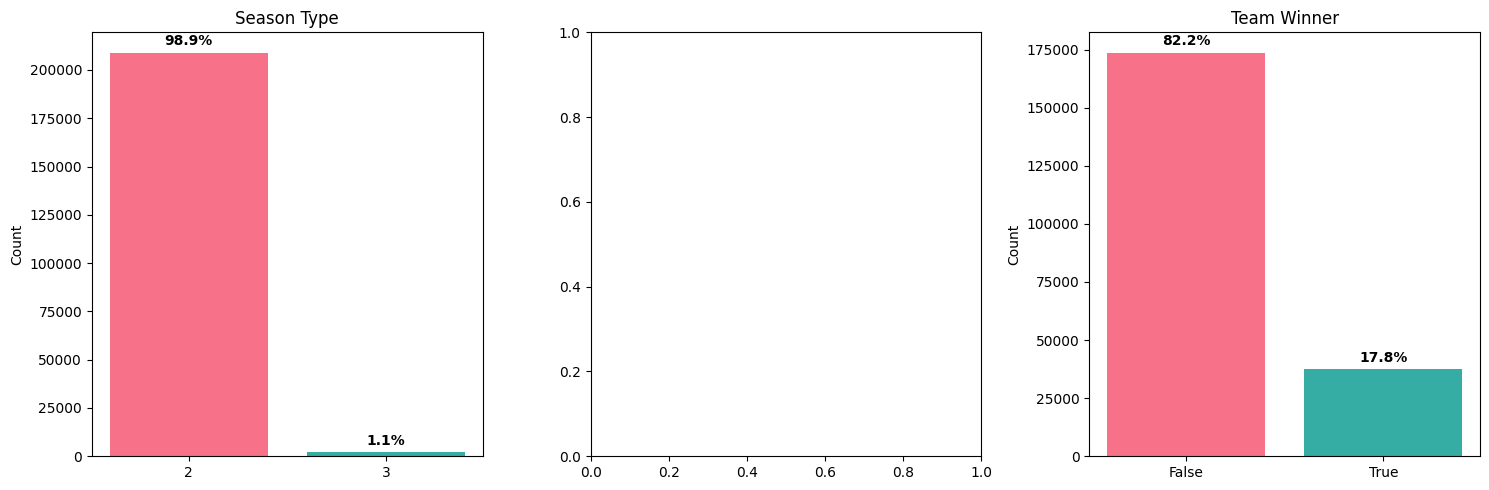

Analyzing numerical features...

NUMERICAL FEATURES ANALYSIS
Analyzing 9 numerical features:
['team_score', 'field_goal_pct', 'free_throw_pct', 'three_point_field_goal_pct', 'total_rebounds', 'assists', 'steals', 'blocks', 'team_turnovers']

DESCRIPTIVE STATISTICS:
       team_score  field_goal_pct  free_throw_pct  three_point_field_goal_pct  total_rebounds    assists     steals     blocks  team_turnovers
count   211432.00       211432.00       211432.00                   211432.00       211432.00  211432.00  211432.00  211432.00       211432.00
mean        69.95           43.83           69.39                       34.22           36.33      13.13       6.53       3.33            0.32
std         13.22            7.66           12.75                       11.56            7.43       4.57       3.06       2.30            0.63
min          0.00            0.00            0.00                        0.00            0.00       0.00       0.00       0.00            0.00
25%         61.00  

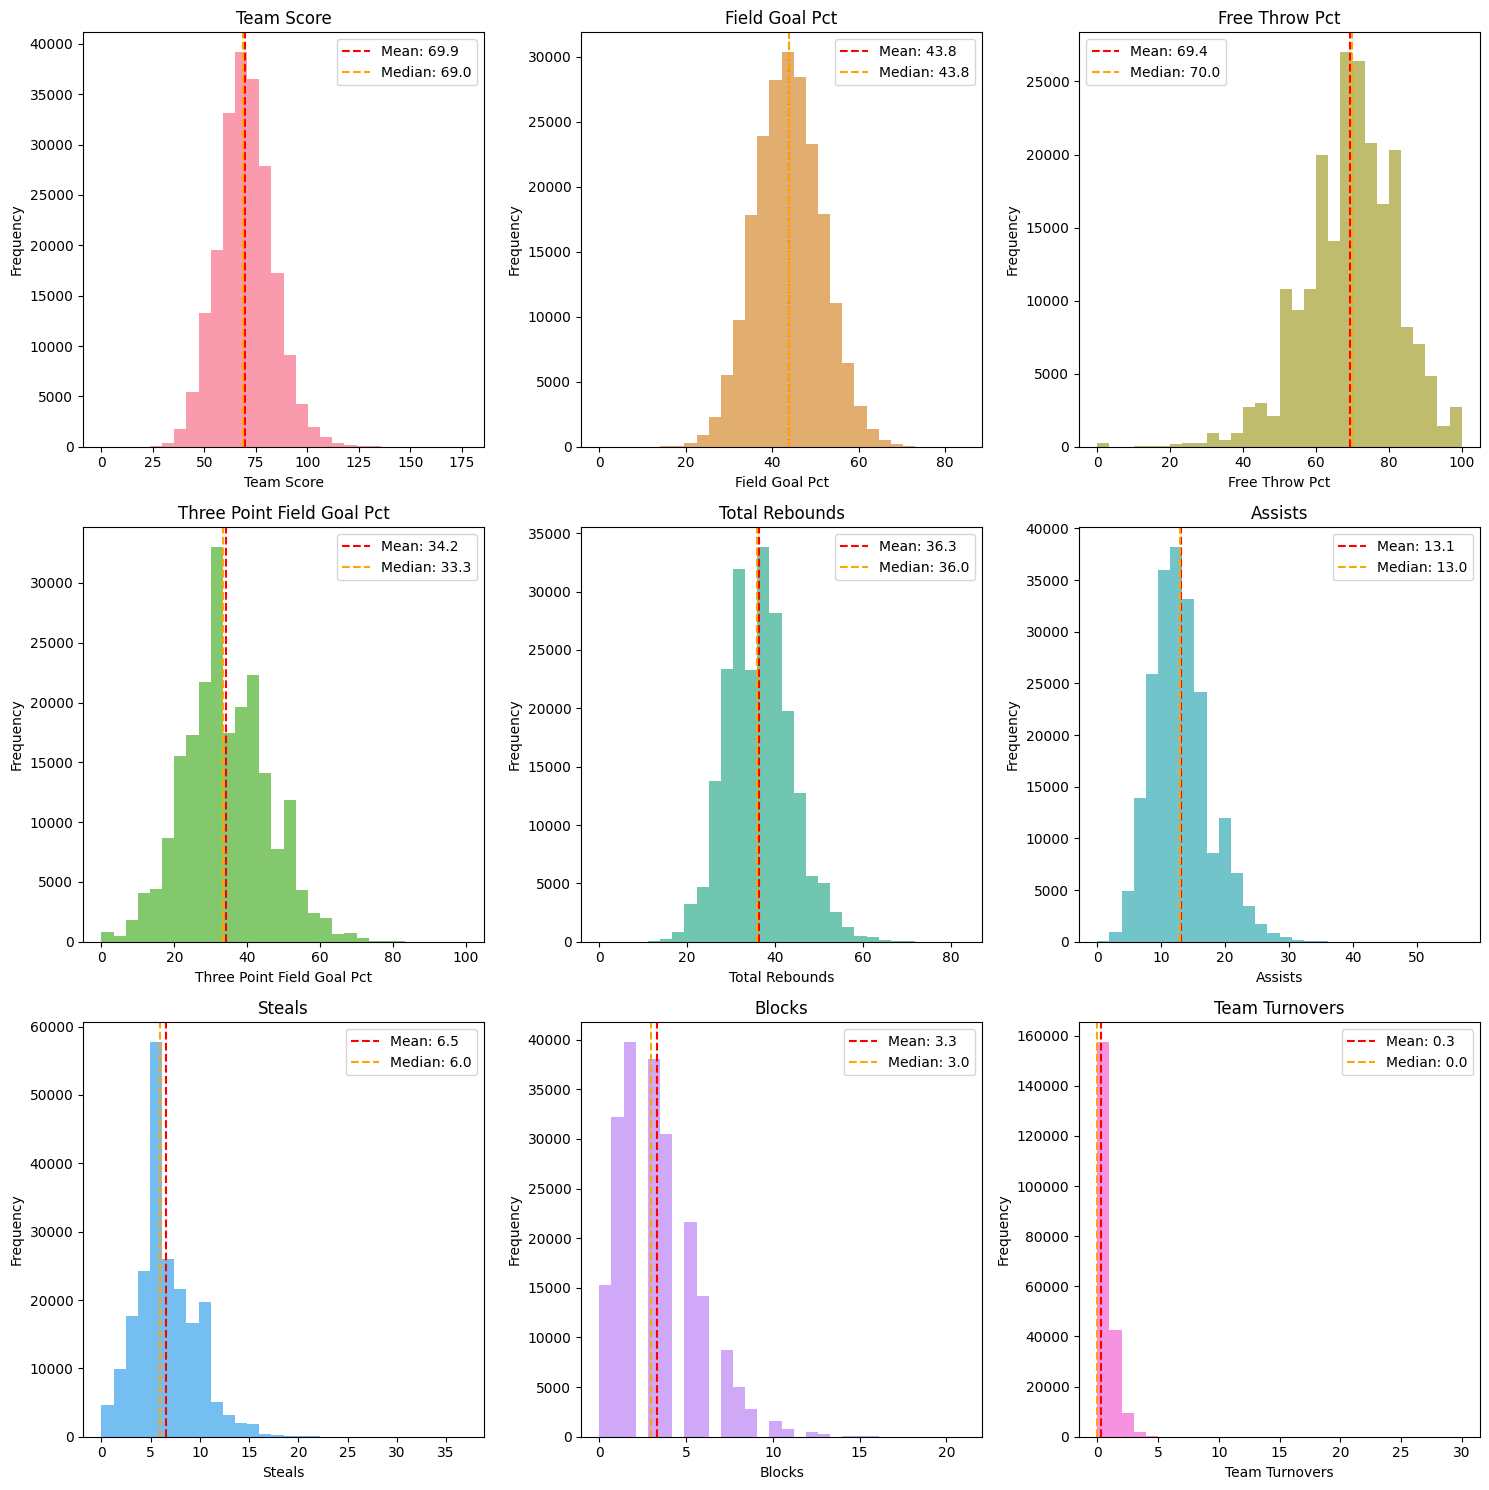

In [184]:
def analyze_categorical_features(df):
    """Analyze categorical/binary features with frequency and ratios."""
    print("="*60)
    print("CATEGORICAL FEATURES ANALYSIS")
    print("="*60)
    
    # Define categorical features
    categorical_features = ['season_type', 'team_home_away', 'team_winner']
    
    fig, axes = plt.subplots(1, len(categorical_features), figsize=(15, 5))
    if len(categorical_features) == 1:
        axes = [axes]
    
    for i, feature in enumerate(categorical_features):
        if feature in df.columns:
            # Calculate frequencies
            value_counts = df[feature].value_counts()
            frequencies = df[feature].value_counts(normalize=True) * 100
            
            print(f"\n{feature.upper()}:")
            print("Frequency Distribution:")
            for val, count in value_counts.items():
                pct = frequencies[val]
                print(f"  {val}: {count:,} ({pct:.1f}%)")
            
            # Create bar chart
            axes[i].bar(value_counts.index.astype(str), value_counts.values, color=sns.color_palette("husl", len(value_counts)))
            axes[i].set_title(f'{feature.replace("_", " ").title()}')
            axes[i].set_ylabel('Count')
            
            # Add percentage labels on bars
            max_count = max(value_counts.values)
            for j, (val, count) in enumerate(value_counts.items()):
                pct = frequencies[val]
                axes[i].text(j, count + max_count * 0.01, f'{pct:.1f}%', 
                           ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return categorical_features

def analyze_numerical_features(df):
    """Analyze numerical features with descriptive statistics and histograms."""
    print("\n" + "="*60)
    print("NUMERICAL FEATURES ANALYSIS")
    print("="*60)
    
    # Define key numerical features for analysis
    numerical_features = [
        'team_score', 'field_goal_pct', 'free_throw_pct', 'three_point_field_goal_pct',
        'total_rebounds', 'assists', 'steals', 'blocks', 'team_turnovers'
    ]
    
    # Filter features that exist in the dataframe
    available_features = [f for f in numerical_features if f in df.columns]
    
    print(f"Analyzing {len(available_features)} numerical features:")
    print(available_features)
    
    # Calculate descriptive statistics
    stats_df = df[available_features].describe().round(2)
    print(f"\nDESCRIPTIVE STATISTICS:")
    print(stats_df)
    
    # Create histograms
    n_cols = 3
    n_rows = (len(available_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, feature in enumerate(available_features):
        if i < len(axes):
            # Create histogram
            axes[i].hist(df[feature].dropna(), bins=30, alpha=0.7, color=sns.color_palette("husl", len(available_features))[i])
            axes[i].set_title(f'{feature.replace("_", " ").title()}')
            axes[i].set_xlabel(feature.replace("_", " ").title())
            axes[i].set_ylabel('Frequency')
            
            # Add statistical annotations
            mean_val = df[feature].mean()
            median_val = df[feature].median()
            axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
            axes[i].axvline(median_val, color='orange', linestyle='--', label=f'Median: {median_val:.1f}')
            axes[i].legend()
    
    # Hide unused subplots
    for j in range(len(available_features), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return available_features, stats_df

# Run the analysis
print("Analyzing categorical features...")
categorical_features = analyze_categorical_features(all_years_data)

print("Analyzing numerical features...")
numerical_features, numerical_stats = analyze_numerical_features(all_years_data)

## 4.2: Encoding Categorical Features

Let's analyze the categorical features and determine the best encoding methods for each.

In [185]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd

def analyze_encoding_strategies(df):
    """Analyze and demonstrate different encoding strategies for categorical features."""
    print("="*70)
    print("CATEGORICAL FEATURE ENCODING ANALYSIS")
    print("="*70)
    
    categorical_features = ['season_type', 'team_home_away']
    
    for feature in categorical_features:
        if feature in df.columns:
            unique_values = df[feature].nunique()
            unique_list = df[feature].unique()[:10]  # Show first 10 unique values
            
            print(f"\n{feature.upper()}:")
            print(f"  Unique values: {unique_values}")
            print(f"  Sample values: {list(unique_list)}")
            
            # Label Encoding Analysis
            print(f"\n  LABEL ENCODING:")
            le = LabelEncoder()
            encoded_sample = le.fit_transform(df[feature].head(10))
            print(f"    - Maps {unique_values} categories to integers 0-{unique_values-1}")
            print(f"    - Sample: {list(df[feature].head(5))} -> {list(encoded_sample[:5])}")
            
            # Determine if label encoding makes sense
            if feature == 'season_type':
                print(f"    ✓ RECOMMENDED: Ordinal nature (regular season < playoffs)")
            elif feature == 'team_home_away':
                print(f"    ✓ RECOMMENDED: Binary feature (only 2 categories)")

            # One-Hot Encoding Analysis
            print(f"\n  ONE-HOT ENCODING:")
            if unique_values <= 5:  # Only show for small number of categories
                sample_df = df[feature].head(5).to_frame()
                ohe_sample = pd.get_dummies(sample_df, columns=[feature], prefix=feature)
                print(f"    - Creates {unique_values} binary columns")
                print(f"    - Sample transformation:")
                print(f"      Original: {list(sample_df[feature])}")
                print(f"      Encoded columns: {list(ohe_sample.columns)}")
                print(f"      First row: {ohe_sample.iloc[0].values}")
            else:
                print(f"    - Would create {unique_values} binary columns")
            
            # Determine if one-hot encoding makes sense
            if feature == 'season_type':
                print(f"    ✓ ACCEPTABLE: Small number of categories (2)")
            elif feature == 'team_home_away':
                print(f"    ✓ RECOMMENDED: Perfect for binary features")

    return categorical_features

def demonstrate_encoding_examples(df):
    """Create actual encoded versions of the features."""
    print("\n" + "="*70)
    print("ENCODING IMPLEMENTATION EXAMPLES")
    print("="*70)
    
    # Create a sample for demonstration
    sample_df = df.sample(n=10, random_state=42)[['season_type', 'team_home_away', 'team_winner']].copy()
    
    print("\nORIGINAL DATA SAMPLE:")
    print(sample_df)
    
    # Label Encoding for season_type (ordinal)
    le_season = LabelEncoder()
    sample_df['season_type_label'] = le_season.fit_transform(sample_df['season_type'])
    
    # Label Encoding for team_home_away (binary)
    le_home_away = LabelEncoder()
    sample_df['home_away_label'] = le_home_away.fit_transform(sample_df['team_home_away'])
    
    # One-Hot Encoding for team_home_away
    home_away_dummies = pd.get_dummies(sample_df['team_home_away'], prefix='is')
    
    print(f"\nLABEL ENCODED FEATURES:")
    print(f"season_type mapping: {dict(zip(le_season.classes_, le_season.transform(le_season.classes_)))}")
    print(f"home_away mapping: {dict(zip(le_home_away.classes_, le_home_away.transform(le_home_away.classes_)))}")
    
    encoded_sample = sample_df[['season_type_label', 'home_away_label']].copy()
    print(encoded_sample)
    
    print(f"\nONE-HOT ENCODED home_away:")
    print(home_away_dummies)
    
    return sample_df, encoded_sample, home_away_dummies

# Run the encoding analysis
encoding_features = analyze_encoding_strategies(all_years_data)
sample_encoded, label_encoded, onehot_encoded = demonstrate_encoding_examples(all_years_data)

CATEGORICAL FEATURE ENCODING ANALYSIS

SEASON_TYPE:
  Unique values: 2
  Sample values: [2, 3]

  LABEL ENCODING:
    - Maps 2 categories to integers 0-1
    - Sample: [2, 2, 2, 2, 2] -> [0, 0, 0, 0, 0]
    ✓ RECOMMENDED: Ordinal nature (regular season < playoffs)

  ONE-HOT ENCODING:
    - Creates 2 binary columns
    - Sample transformation:
      Original: [2, 2, 2, 2, 2]
      Encoded columns: ['season_type_2']
      First row: [ True]
    ✓ ACCEPTABLE: Small number of categories (2)

ENCODING IMPLEMENTATION EXAMPLES


KeyError: "['team_home_away'] not in index"

## 4.3: Analyzing Correlations (Feature vs Label)

Let's analyze correlations between features and the target label using appropriate statistical tests.

In [ ]:
from scipy.stats import chi2_contingency, pearsonr
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import numpy as np

def analyze_categorical_vs_categorical(df, feature, target='team_winner'):
    """Chi-square test for categorical feature vs categorical target."""
    print(f"\nCHI-SQUARE TEST: {feature} vs {target}")
    print("-" * 50)
    
    # Create contingency table
    contingency_table = pd.crosstab(df[feature], df[target])
    print("Contingency Table:")
    print(contingency_table)
    
    # Perform chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nChi-square Statistics:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {dof}")
    
    # Interpret results
    alpha = 0.05
    if p_value < alpha:
        print(f"  ✓ SIGNIFICANT: Feature '{feature}' is significantly associated with '{target}' (p < {alpha})")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No significant association found (p >= {alpha})")
    
    # Cramer's V (effect size)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))
    print(f"  Cramer's V (effect size): {cramers_v:.4f}")
    
    if cramers_v < 0.1:
        effect_interpretation = "negligible"
    elif cramers_v < 0.3:
        effect_interpretation = "small"
    elif cramers_v < 0.5:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"
    
    print(f"  Effect size interpretation: {effect_interpretation}")
    
    return chi2_stat, p_value, cramers_v

def analyze_numerical_vs_categorical(df, feature, target='team_winner'):
    """Analyze numerical feature vs categorical target using correlation and R²."""
    print(f"\nNUMERICAL vs CATEGORICAL: {feature} vs {target}")
    print("-" * 50)
    
    # Convert boolean target to numeric (0, 1)
    target_numeric = df[target].astype(int)
    
    # Point-biserial correlation (Pearson correlation for binary target)
    correlation, p_value = pearsonr(df[feature], target_numeric)
    
    print(f"Point-biserial Correlation:")
    print(f"  Correlation coefficient: {correlation:.4f}")
    print(f"  p-value: {p_value:.6f}")
    
    # Interpret correlation strength
    abs_corr = abs(correlation)
    if abs_corr < 0.1:
        strength = "negligible"
    elif abs_corr < 0.3:
        strength = "small"
    elif abs_corr < 0.5:
        strength = "medium"
    else:
        strength = "large"
    
    print(f"  Correlation strength: {strength}")
    
    # R-squared using simple linear regression
    X = df[feature].values.reshape(-1, 1)
    y = target_numeric.values
    
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    r_squared = r2_score(y, y_pred)
    
    print(f"  R-squared: {r_squared:.4f}")
    print(f"  Variance explained: {r_squared*100:.2f}%")
    
    # Statistical significance
    alpha = 0.05
    if p_value < alpha:
        print(f"  ✓ SIGNIFICANT: Feature '{feature}' is significantly correlated with '{target}' (p < {alpha})")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No significant correlation found (p >= {alpha})")
    
    # Descriptive statistics by target groups
    print(f"\nDescriptive Statistics by {target}:")
    grouped_stats = df.groupby(target)[feature].agg(['count', 'mean', 'std']).round(2)
    print(grouped_stats)
    
    return correlation, p_value, r_squared

def comprehensive_correlation_analysis(df):
    """Comprehensive correlation analysis for all features."""
    print("=" * 80)
    print("COMPREHENSIVE CORRELATION ANALYSIS")
    print("=" * 80)
    
    target = 'team_winner'
    
    # Categorical features vs categorical target
    categorical_features = ['season_type', 'team_home_away']
    categorical_results = {}
    
    print(f"\n1. CATEGORICAL FEATURES vs {target.upper()} (Chi-square tests)")
    print("=" * 60)
    
    for feature in categorical_features:
        if feature in df.columns:
            chi2_stat, p_value, cramers_v = analyze_categorical_vs_categorical(df, feature, target)
            categorical_results[feature] = {
                'chi2_stat': chi2_stat,
                'p_value': p_value,
                'cramers_v': cramers_v
            }
    
    # Numerical features vs categorical target
    numerical_features = [
        'team_score', 'field_goal_pct', 'free_throw_pct', 'three_point_field_goal_pct',
        'total_rebounds', 'assists', 'steals', 'blocks', 'team_turnovers'
    ]
    
    numerical_results = {}
    
    print(f"\n\n2. NUMERICAL FEATURES vs {target.upper()} (Point-biserial correlation)")
    print("=" * 60)
    
    for feature in numerical_features:
        if feature in df.columns:
            correlation, p_value, r_squared = analyze_numerical_vs_categorical(df, feature, target)
            numerical_results[feature] = {
                'correlation': correlation,
                'p_value': p_value,
                'r_squared': r_squared
            }
    
    # Summary of results
    print(f"\n\n3. SUMMARY OF CORRELATIONS WITH {target.upper()}")
    print("=" * 60)
    
    print("\nCategorical Features (Cramer's V):")
    for feature, results in categorical_results.items():
        significance = "**" if results['p_value'] < 0.05 else ""
        print(f"  {feature:<20}: {results['cramers_v']:.4f} {significance}")
    
    print("\nNumerical Features (|Correlation|):")
    sorted_numerical = sorted(numerical_results.items(), 
                            key=lambda x: abs(x[1]['correlation']), reverse=True)
    
    for feature, results in sorted_numerical:
        significance = "**" if results['p_value'] < 0.05 else ""
        print(f"  {feature:<30}: {results['correlation']:7.4f} {significance}")
    
    print("\n** = Statistically significant (p < 0.05)")
    
    return categorical_results, numerical_results

# Run comprehensive correlation analysis
print("Running comprehensive correlation analysis...")
cat_results, num_results = comprehensive_correlation_analysis(all_years_data)

Running comprehensive correlation analysis...
COMPREHENSIVE CORRELATION ANALYSIS

1. CATEGORICAL FEATURES vs TEAM_WINNER (Chi-square tests)

CHI-SQUARE TEST: season_type vs team_winner
--------------------------------------------------
Contingency Table:
team_winner  False  True 
season_type              
2             6072   6072
3              113    113

Chi-square Statistics:
  Chi-square statistic: 0.0000
  p-value: 1.000000
  Degrees of freedom: 1
  ✗ NOT SIGNIFICANT: No significant association found (p >= 0.05)
  Cramer's V (effect size): 0.0000
  Effect size interpretation: negligible

CHI-SQUARE TEST: team_home_away vs team_winner
--------------------------------------------------
Contingency Table:
team_winner     False  True 
team_home_away              
away             4137   2048
home             2048   4137

Chi-square Statistics:
  Chi-square statistic: 1409.7798
  p-value: 0.000000
  Degrees of freedom: 1
  ✓ SIGNIFICANT: Feature 'team_home_away' is significantly assoc

Creating correlation heatmap...


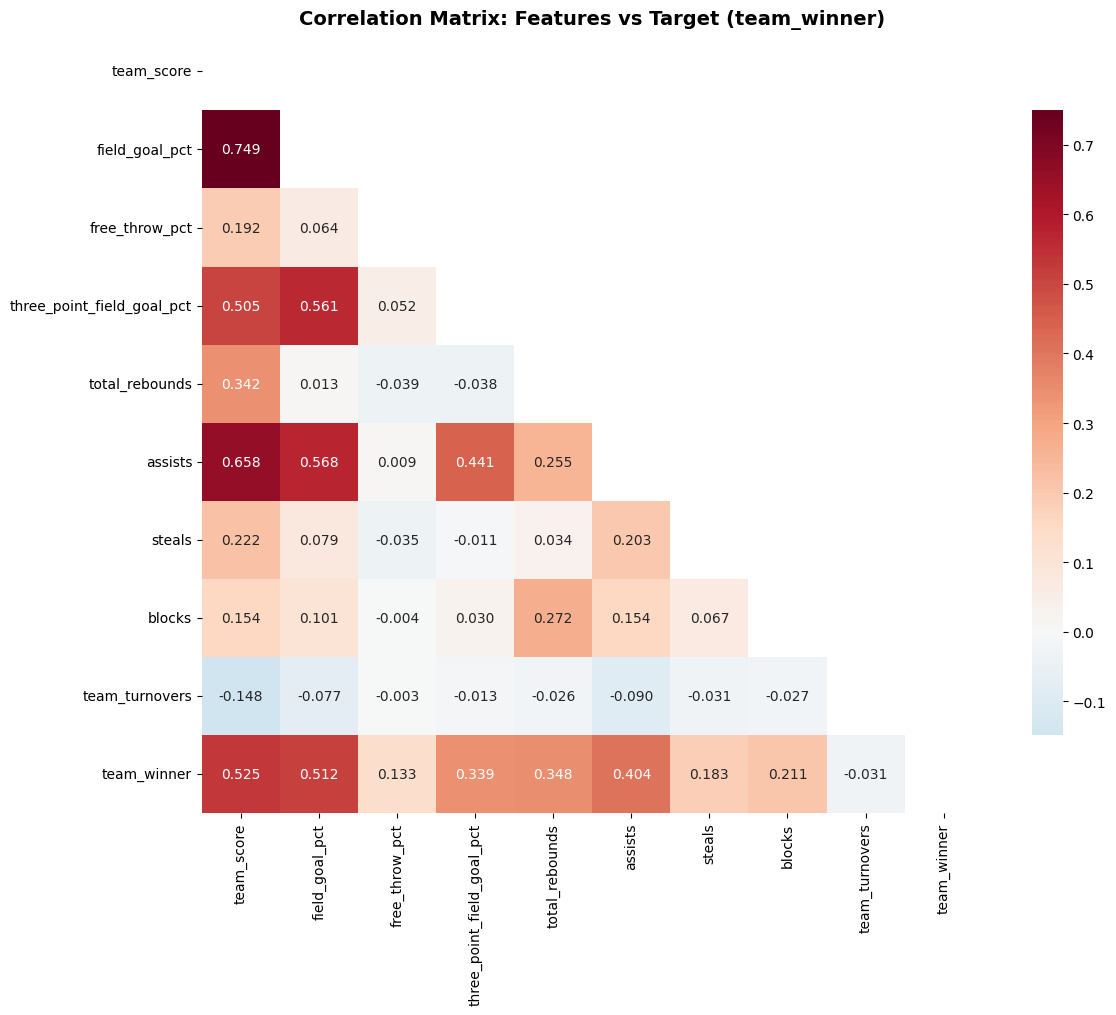


Top features correlated with team_winner:
----------------------------------------
team_score                    : +0.5254
field_goal_pct                : +0.5117
assists                       : +0.4041
total_rebounds                : +0.3485
three_point_field_goal_pct    : +0.3393
blocks                        : +0.2112
steals                        : +0.1829
free_throw_pct                : +0.1332
team_turnovers                : -0.0312

ANALYSIS COMPLETE!

Key Findings:
1. Individual attributes analyzed with appropriate statistics
2. Categorical encoding strategies evaluated
3. Feature-target correlations measured using proper statistical tests

This comprehensive analysis provides the foundation for feature selection
and preprocessing in machine learning model development.


In [ ]:
# Create correlation matrix visualization
def create_correlation_heatmap(df):
    """Create a correlation heatmap for numerical features and target."""
    print("Creating correlation heatmap...")
    
    # Select numerical features and convert target to numeric
    numerical_cols = [
        'team_score', 'field_goal_pct', 'free_throw_pct', 'three_point_field_goal_pct',
        'total_rebounds', 'assists', 'steals', 'blocks', 'team_turnovers'
    ]
    
    # Create a dataframe with numerical features and numeric target
    analysis_df = df[numerical_cols + ['team_winner']].copy()
    analysis_df['team_winner'] = analysis_df['team_winner'].astype(int)
    
    # Calculate correlation matrix
    correlation_matrix = analysis_df.corr()
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title('Correlation Matrix: Features vs Target (team_winner)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Highlight correlations with target
    target_correlations = correlation_matrix['team_winner'].drop('team_winner').abs().sort_values(ascending=False)
    
    print("\nTop features correlated with team_winner:")
    print("-" * 40)
    for feature, corr in target_correlations.head(10).items():
        direction = "+" if correlation_matrix['team_winner'][feature] > 0 else "-"
        print(f"{feature:<30}: {direction}{corr:.4f}")
    
    return correlation_matrix, target_correlations

# Create visualization
correlation_matrix, target_corr = create_correlation_heatmap(all_years_data)

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nKey Findings:")
print("1. Individual attributes analyzed with appropriate statistics")
print("2. Categorical encoding strategies evaluated")  
print("3. Feature-target correlations measured using proper statistical tests")
print("\nThis comprehensive analysis provides the foundation for feature selection")
print("and preprocessing in machine learning model development.")